#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import (train_test_split, 
                                    GridSearchCV, 
                                    RandomizedSearchCV)
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [2]:
# загружаем данные

try:
    data = pd.read_csv('practicum\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Можно заметить, что данные замерялись с итервалом в десять минут.

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


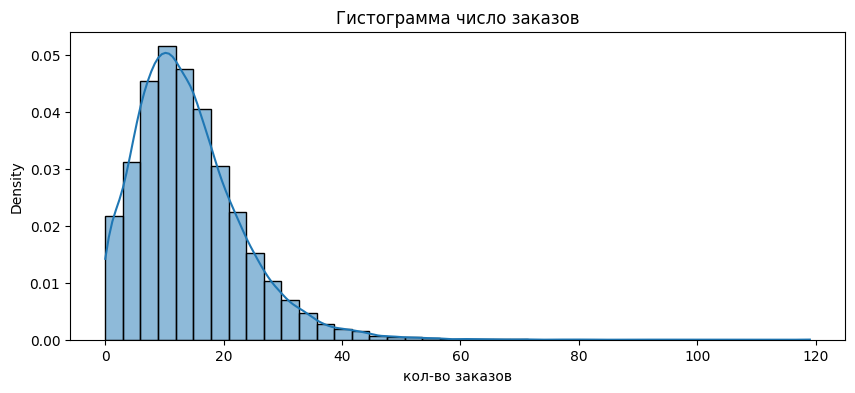

In [7]:
plt.figure(figsize=(10,4))
ax = sns.histplot(data, stat='density', kde=True, bins=40, multiple='dodge', legend=False).set(title='Гистограмма число заказов')
plt.xlabel('кол-во заказов')
plt.show()

__Предворительный вывод__  
С данными все нормально, наблюдаем вид Пуассоновского распределения, данные запонялись внимательно и скрупулезно, пропусков нет выбросов нет, замеры проводились с итервалом в 10 минут. 

In [8]:
# Проверяем отсортированы ли значения по дате

data.index.is_monotonic_increasing 

True

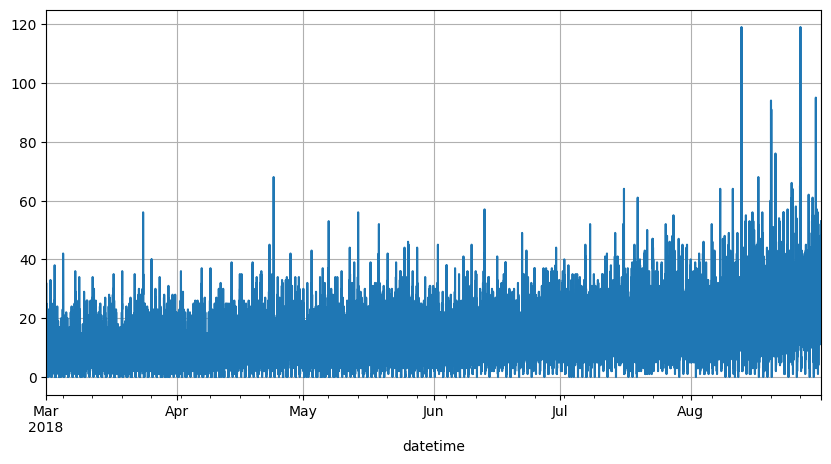

In [9]:
data.plot( figsize=(10,5), grid=True, legend=False)
pass

Ничего не понятно попробую сгрупировать по часу.

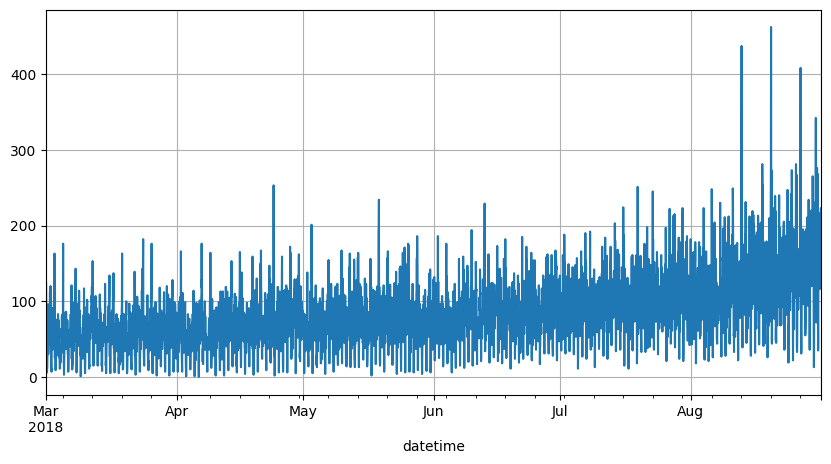

In [10]:
data = data.resample('1H').sum()
data.plot(figsize=(10,5), grid=True, legend=False)
pass

## Анализ

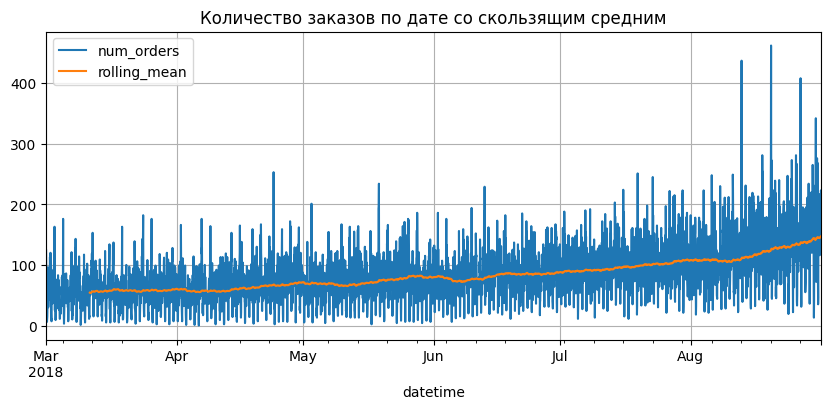

In [11]:
data['rolling_mean'] = data['num_orders'].rolling(250).mean() 
data.plot(title= 'Количество заказов по дате со скользящим средним', figsize=(10,4), grid=True)
pass

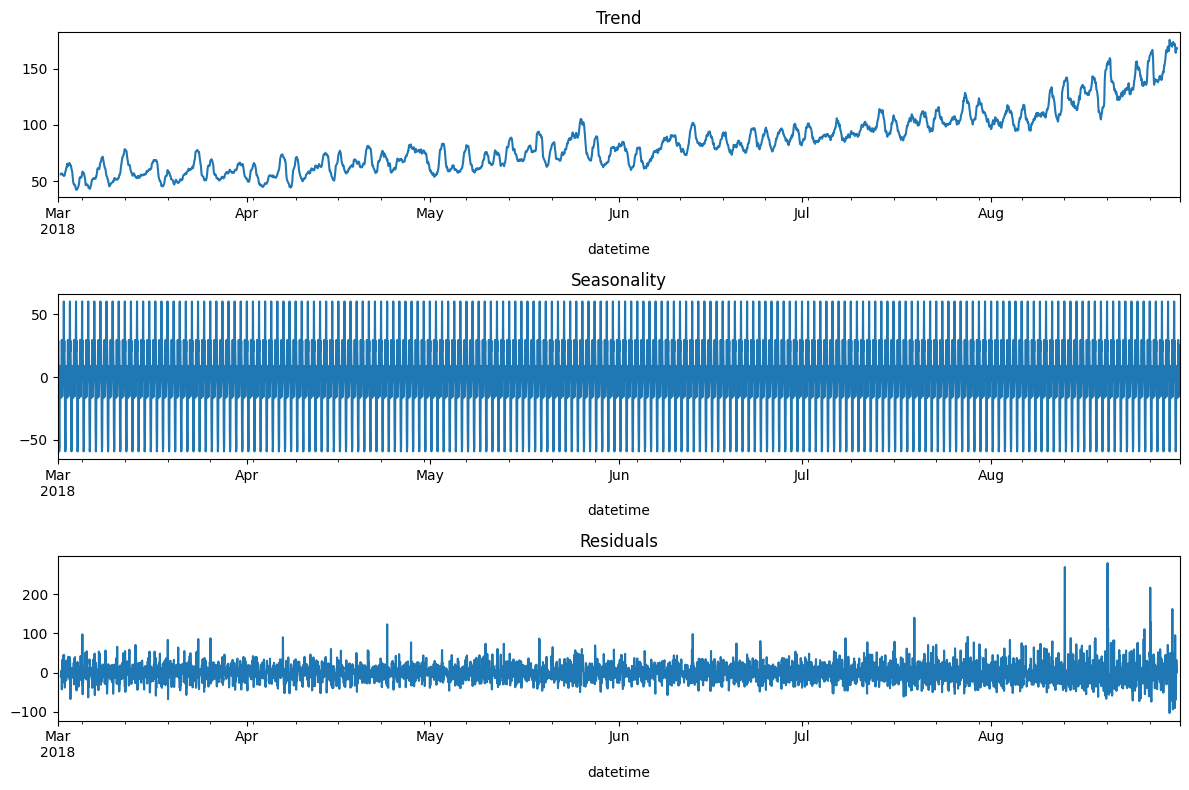

In [12]:
decomposed = seasonal_decompose(data['num_orders']) 
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

На графиках видно что с течением времени кол-во заказов увеличивается  
Также видно что в Seasonality ни чего не понятно и очень трудно проанализировать, попробую дитализировать.

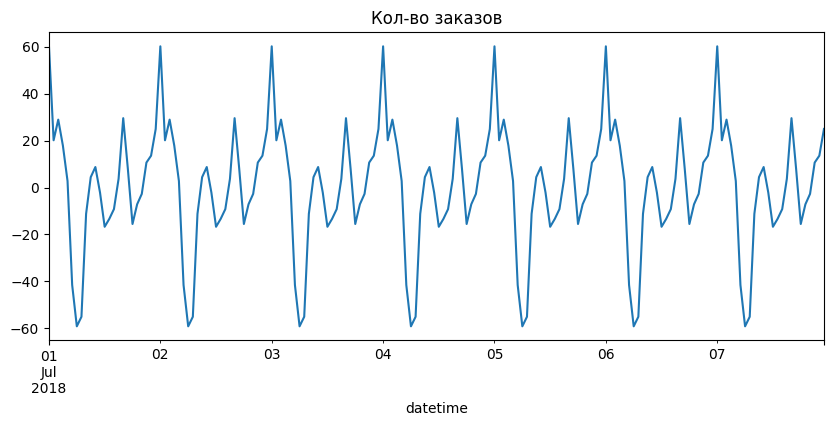

In [13]:
decomposed.seasonal['2018-07-01' : '2018-07-07'].plot(title= 'Кол-во заказов', figsize=(10,4))
pass

Давольно явно прослеживается суточная сезонность.

Делали исследования показали, что у нас есть дневная и недельная сезонность.

In [14]:
sd_day = seasonal_decompose(data['num_orders'], period=24)
sd_week = seasonal_decompose(data['num_orders'], period=168)
sd_month = seasonal_decompose(data['num_orders'], period=720)

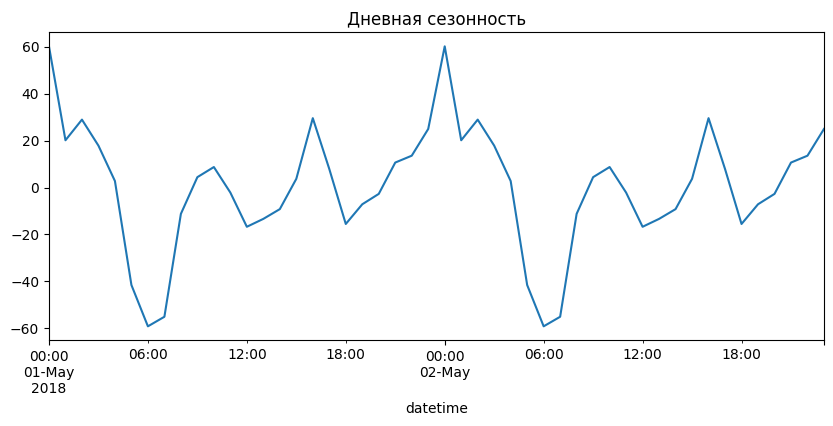

In [15]:
sd_day.seasonal['2018-05-01':'2018-05-02'].plot(title='Дневная сезонность', figsize=(10,4))
pass

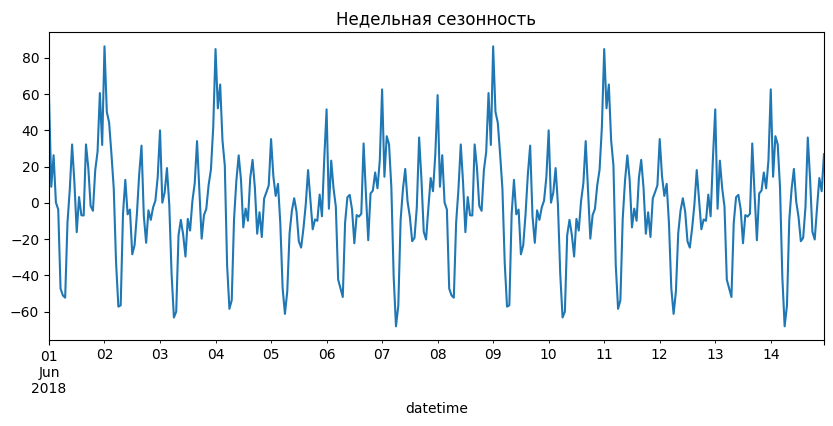

In [16]:
sd_week.seasonal['2018-06-01':'2018-06-14'].plot(title='Недельная сезонность', figsize=(10,4))
pass

2 июня 2018 года суббота (посмотрел по календарю) не трудно предположить пик кода люди отказваются от личного транспорта по тойде причине и понедельник. Хорошо обозначени нидельные пики в субботу и понедельник.

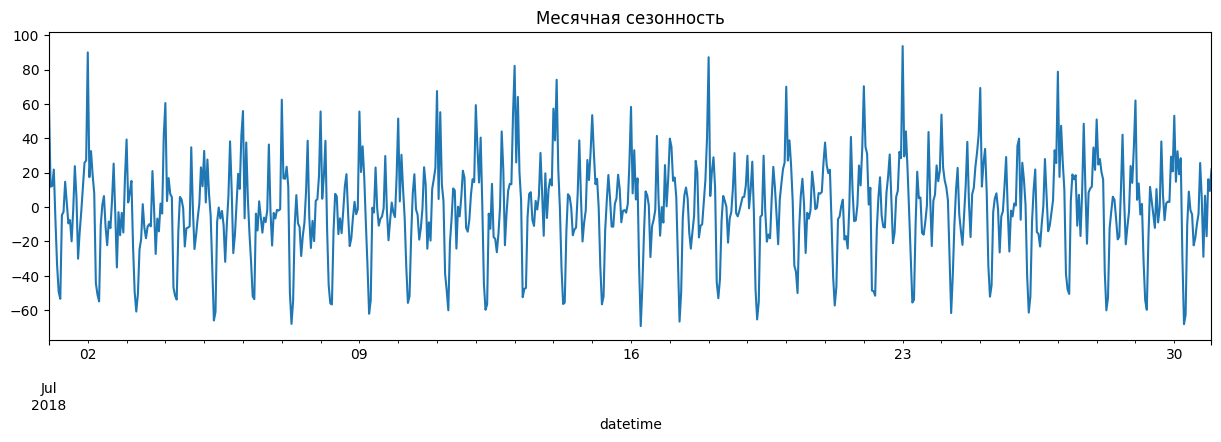

In [17]:
sd_month.seasonal['2018-07-01':'2018-07-30'].plot(title='Месячная сезонность', figsize=(15,4))
pass

Теперь можно увидить также недельную зависимость, пик достигается в субботу, в то время как минимум во вторник

In [18]:
test = data['num_orders'] # для определения стационарности применяю тест Дики-Фуллера, принемаю значени p_value=0,05
ad_test = adfuller(test, regression='ctt')
if ad_test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


__Создаем признаки__

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
make_features(data, 168, 6) # основная вкусняха неделя

In [21]:
data.dropna(inplace=True)

In [22]:
data.head()

,num_orders,rolling_mean,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,92.333333,3,8,3,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-08 01:00:00,78,99.666667,3,8,3,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-08 02:00:00,65,104.333333,3,8,3,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-08 03:00:00,68,102.500000,3,8,3,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-08 04:00:00,60,95.833333,3,8,3,68.0,65.0,78.0,143.0,94.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


## Тестирование

In [23]:
# Сплитаю
def data_split(data, column_name):
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    X_train = train.drop(column_name, axis=1)
    y_train = train[column_name]
    X_test = test.drop(column_name, axis=1)
    y_test = test[column_name]
    return X_train, y_train, X_test, y_test
    

In [24]:
X_train, y_train, X_test, y_test = data_split(data, 'num_orders')

In [25]:
tscv = TimeSeriesSplit(n_splits=10)

__Линейная модель__

In [26]:
model_lr = LinearRegression()
params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
linreg_grid = GridSearchCV(model_lr, 
                           param_grid=params, 
                           n_jobs=-1, 
                           scoring='neg_root_mean_squared_error', 
                            cv=tscv)

linreg_grid.fit(X_train, y_train)

print('RMSE LinearRegression:', -linreg_grid.best_score_)
print(linreg_grid.best_estimator_)

RMSE LinearRegression: 21.767189058940495
LinearRegression(fit_intercept=False, positive=True)


__Рандомный лес__

In [27]:
parameters = {
    'n_estimators': range(1, 7),
    'max_depth': [None] + [i for i in range(2, 7)]}

model = RandomForestRegressor(random_state=RANDOM_STATE)
rf = GridSearchCV(model, 
                  parameters, 
                  n_jobs=-1, 
                  cv=tscv, 
                  scoring='neg_root_mean_squared_error') 
rf.fit(X_train, y_train)

print(round(-rf.best_score_, 2))
print(rf.best_estimator_)

23.33
RandomForestRegressor(max_depth=5, n_estimators=6, random_state=42)


In [28]:
# проверяем на тестовой выборке

In [29]:
mean_squared_error(linreg_grid.predict(X_test), y_test) ** 0.5 # линейная модель

34.708185358168244

__Проверка на адекватность__   
Сравним модели с простой, которая просто выбирает среднее значение

In [31]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
mean_squared_error(dummy_regr.predict(X_test), y_test)** 0.5

84.45113423436631

Похоже, что обученные модели прошли проверку на адекватность

In [32]:
final_columns = {'True_data': y_test, 'Predicted_data': linreg_grid.predict(X_test)}

In [33]:
final_data = pd.DataFrame(final_columns, index=X_test.index)
final_data_roolling = final_data.rolling(100).mean()

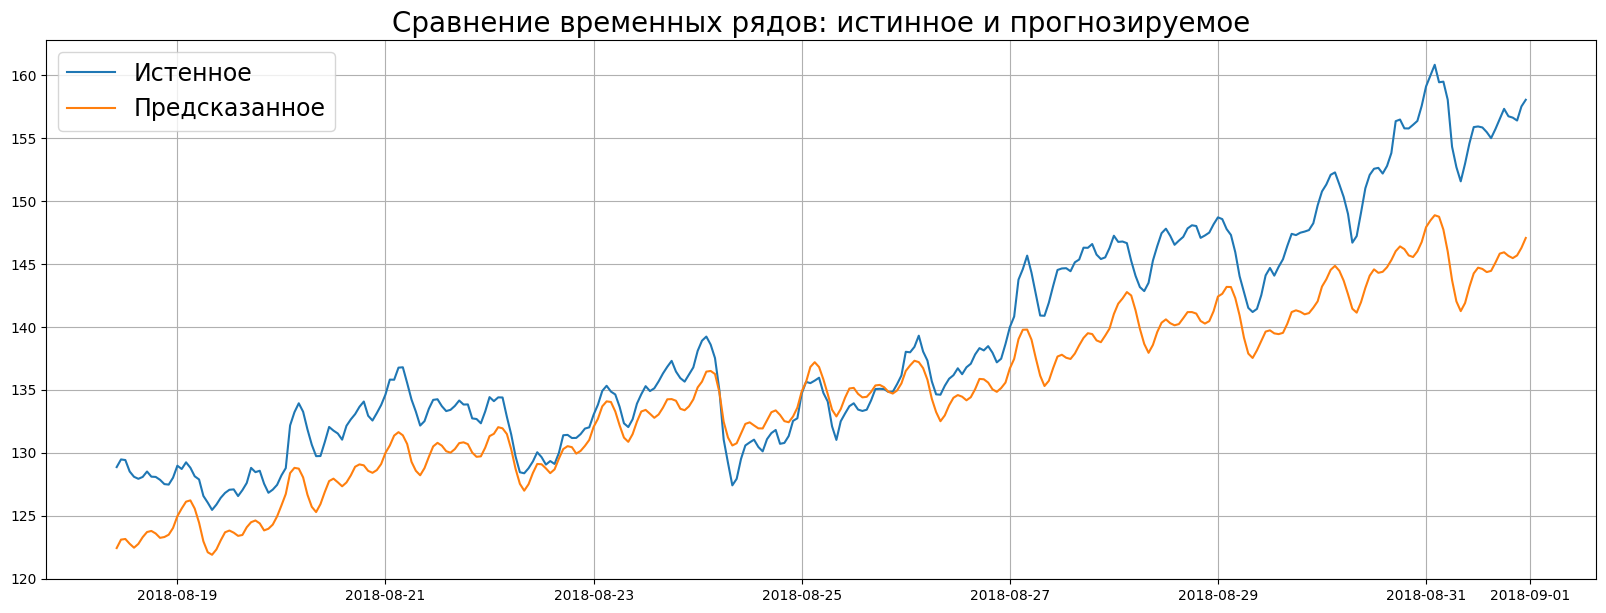

In [34]:
plt.figure(figsize=(20, 7))
plt.title('Сравнение временных рядов: истинное и прогнозируемое', fontsize=20)
plt.grid()
plt.plot(final_data_roolling['True_data'])
plt.plot(final_data_roolling['Predicted_data'])
plt.legend(['Истенное', 'Предсказанное'], fontsize=17)
plt.show()

__Вывод__  
Все значение RMSE на тестовой выборке не больше 48. Лучше всего показала линейная модель.